In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import group_nation_by_continent, normalize_min_max
from sklearn import cluster as skc
from sklearn.metrics import silhouette_score
%matplotlib inline

### Load sample

In [2]:
generated_path = './../../generated/'
file_name = 'sample.csv'
df_sample = pd.read_csv(generated_path + file_name)

In [3]:
df_sample = df_sample.head(20000)

### Create different dataframes from sample

In [13]:
selected_feats = [',_per_sentence', 'sign_per_token', 'approx_word_count', 'token_count', 'adj_per_word', 'verb_per_word', 'base_ratio', 'pres_ratio', 'past_ratio', 'pronoun_per_word', 'sentiment']
selected_feats = ['token_count', 'self_ratio', 'union_ratio', 'verb_per_word', 'pronoun_per_word', 'sentiment']
speaker_feats = ['date_of_birth', 'nationality', 'gender', 'occupation', 'academic_degree', 'religion']

df_language = df_sample[selected_feats]
df_normalized = normalize_min_max(df_language)

df_speaker = df_sample[speaker_feats]
# replace nation by continent in nationality column
df_speaker = group_nation_by_continent(df_speaker)

/opt/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [14]:
df_normalized.head()

,token_count,self_ratio,union_ratio,verb_per_word,pronoun_per_word,sentiment
0,0.042755,0.500,0.500,0.428571,0.158730,0.609491
1,0.009501,0.500,0.500,0.214286,0.000000,0.383648
2,0.370546,0.125,0.875,0.281879,0.089485,0.537450
3,0.023753,0.500,0.500,0.250000,0.000000,0.490566
4,0.004751,0.500,0.500,0.300000,0.000000,0.776444


### Generate clusters

In [15]:
# Cluster with different distance thresholds and choose clusters with highest silhouette score

thresholds = [1 + 0.2 * i for i in range(5)]
best_labels = []
best_score = -1
best_cluster_n = 0

for i, threshold in enumerate(thresholds):
    model = skc.AgglomerativeClustering(n_clusters = None, linkage = 'complete', distance_threshold = threshold)
    model.fit(df_normalized)
    model_score = silhouette_score(df_normalized, model.labels_)
    print("Threshold {} gave silhouette score {}.".format(threshold, model_score))
    if best_score < model_score:
        best_score = model_score
        best_labels = model.labels_
        best_cluster_n = model.n_clusters_

print("{} clusters was generated with silhouette score {}.".format(best_cluster_n, best_score))

# add best cluster labels to speaker attributes
df_speaker['cluster'] = best_labels

Threshold 1.0 gave silhouette score 0.20553051764489683.
Threshold 1.2 gave silhouette score 0.46790748634372004.
Threshold 1.4 gave silhouette score 0.4898438388615811.
Threshold 1.6 gave silhouette score 0.3980127412024988.
Threshold 1.8 gave silhouette score 0.36223483657794237.
5 clusters was generated with silhouette score 0.4898438388615811.


### Plot speaker attribute distribution within clusters

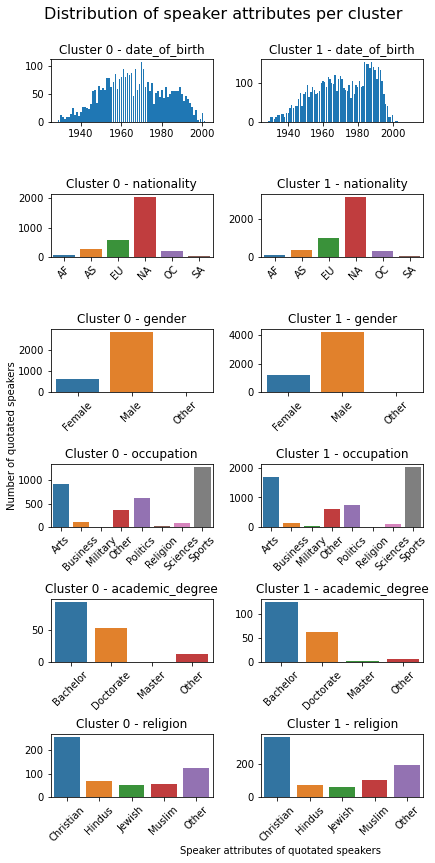

In [16]:
n_clusters = model.n_clusters_
n_speaker_feats = len(speaker_feats)
fig, axes = plt.subplots(n_speaker_feats, n_clusters, figsize = (n_clusters * 3, n_speaker_feats * 2), sharey = False)

for speaker_feat_idx, speaker_feat in enumerate(speaker_feats):
    clusters_curr_feat = df_speaker.groupby(['cluster', speaker_feat]).size().reset_index(level=[0,1])
    use_sns = True
    if speaker_feat == 'date_of_birth':
        use_sns = False
    for cluster_i in range(n_clusters):
        axis = axes[speaker_feat_idx, cluster_i]
        cluster = clusters_curr_feat[clusters_curr_feat['cluster'] == cluster_i]
        values = cluster[0]
        labels = cluster[speaker_feat]
        if use_sns:
            sns.barplot(x = labels, y = values, ax = axis)
            axis.set_xticklabels(labels, rotation = 45, fontsize = 10)
        else:
            axis.bar(labels, values)
        axis.set_title("Cluster {} - {}".format(cluster_i, speaker_feat))
        axis.set(ylabel = None, xlabel = None)

fig.tight_layout()
fig.text(0.4,0, "Speaker attributes of quotated speakers")
fig.text(0,0.4, "Number of quotated speakers", rotation = 90)
fig.suptitle("Distribution of speaker attributes per cluster", fontsize = 16)
plt.subplots_adjust(top=0.92)